# CORELS - um modelo interpretável

In [ ]:
# !sudo apt install graphviz -y
# !pip install corels graphviz numpy pandas seaborn shap xgboost

In [2]:
from corels import CorelsClassifier

try:
    from IPython.display import SVG, display
    from graphviz import Source
except:
    print('Não vai ter graphviz')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import shap
from sklearn import tree
from sklearn.metrics import accuracy_score
import xgboost

Não vai ter graphviz


In [26]:
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Exemplo do [repositório](https://github.com/fingoldin/pycorels)

In [4]:
# ["loud", "samples"] is the most verbose setting possible
C = CorelsClassifier(max_card=2, c=0.0, verbosity=["loud", "samples"])

# 4 samples, 3 features
X = [[1, 0, 1], [0, 0, 0], [1, 1, 0], [0, 1, 0]]
y = [1, 0, 0, 1]
# Feature names
features = ["Mac User", "Likes Pie", "Age < 20"]

# Fit the model
C.fit(X, y, features=features, prediction_name="Has a dirty computer")

# Print the resulting rulelist
print(C.rl())

# Predict on the training set
print(C.predict(X))

RULELIST:
if [not Likes Pie && not Age < 20]:
  Has a dirty computer = False
else if [Mac User && Likes Pie]:
  Has a dirty computer = False
else 
  Has a dirty computer = True
[ True False False  True]


## Exemplo **mais** simples

* feature: is_plus

In [5]:
plus = np.random.randint(0, high=2, size=1000)

* feature: random

In [6]:
rand = np.random.random(size=1000)
rand = np.array(rand < 0.5, dtype=int)

In [64]:
plus[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [65]:
rand[:10]

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [7]:
features = ['is_plus', 'rand < 0.5']

* target construído para ter relação com feature `is_plus`

In [8]:
target = [int(np.random.random() < (0.9 if plus[i] == 1 else 0.1)) for i in range(1000)]

In [9]:
C = CorelsClassifier(max_card=2, c=0.0, verbosity=["loud", "samples"])

In [10]:
X = np.vstack([plus, rand]).transpose()
y = target[:]

In [11]:
C.fit(X, y, features=features, prediction_name="legal")

CorelsClassifier ({'c': 0.0, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': ['loud', 'samples'], 'ablation': 0, 'max_card': 2, 'min_support': 0.01})
RULELIST:
if [is_plus]:
  legal = True
else 
  legal = False
All features: (['is_plus', 'rand < 0.5'])

In [12]:
C.score(X, y)

0.914

### Comparação com uma árvore de decisão

In [13]:
estimator = tree.DecisionTreeClassifier()
estimator.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

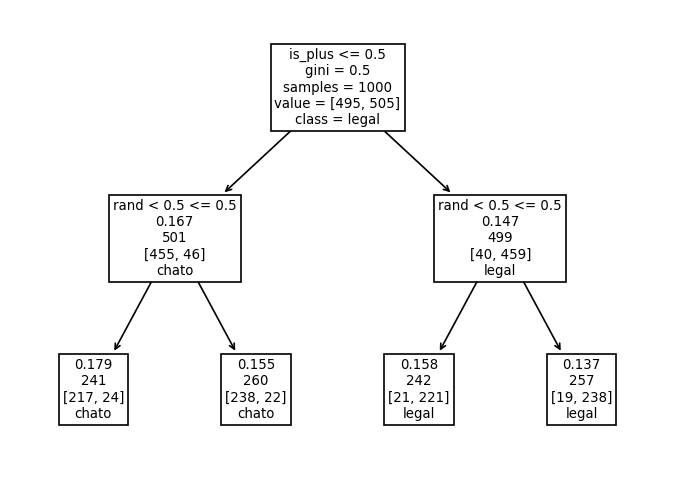

In [14]:
try:
    graph = Source(tree.export_graphviz(estimator, out_file=None, feature_names=features, class_names=['chato', 'legal'],
       filled = True))
    display(SVG(graph.pipe(format='svg')))
    
except:
    # usar se graphviz não funcionar
    fig = plt.figure(figsize=(7, 5), dpi=120)
    ax = fig.add_subplot(111)
    _ = tree.plot_tree(estimator, max_depth=None, label='root', proportion=False,
        feature_names=features, class_names=['chato', 'legal'], ax=ax, fontsize=8)

In [15]:
estimator.score(X, y)

0.914

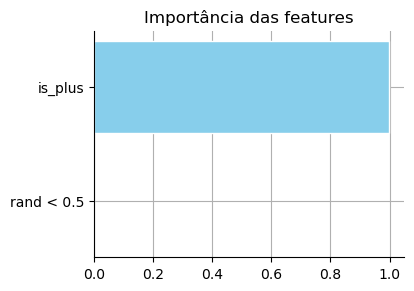

In [16]:
sorted_features = sorted(zip(features, estimator.feature_importances_), key=lambda elem: elem[1], reverse=True)

plt.rcParams['axes.axisbelow'] = True

fig = plt.figure(figsize=(4, 3), dpi=100)
plt.barh(*zip(*sorted_features[:20][::-1]), color='skyblue', edgecolor='w')
plt.grid()
plt.title('Importância das features')
sns.despine()
plt.show()

## Usando dataset mais "real"

Dataset usado pelo manifesto [Beware Default Random Forest Importances](https://explained.ai/rf-importance/):

> To prepare educational material on regression and classification with Random Forests (RFs), we pulled data from [Kaggle's Two Sigma Connect: Rental Listing Inquiries competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries) and selected a few columns.

In [17]:
!wget -O ~/rent.csv https://github.com/parrt/random-forest-importances/raw/master/notebooks/data/rent.csv
!mkdir -p ~/tmp_data
!mv ~/rent.csv ~/tmp_data

--2019-11-29 19:04:43--  https://github.com/parrt/random-forest-importances/raw/master/notebooks/data/rent.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/parrt/random-forest-importances/master/notebooks/data/rent.csv [following]
--2019-11-29 19:04:43--  https://raw.githubusercontent.com/parrt/random-forest-importances/master/notebooks/data/rent.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1483138 (1.4M) [text/plain]
Saving to: ‘/home/jovyan/rent.csv’

/home/jovyan/rent.c 100%[===================>]   1.41M  --.-KB/s    in 0.02s   

2019-11-29 19:04:43 (65.6 MB/s) - ‘/home/jovyan/rent.csv’ saved [1483138/1483138]



In [18]:
df = pd.read_csv(f'{os.path.expanduser("~")}/tmp_data/rent.csv')
df['random'] = np.random.random(size=len(df))

In [19]:
df.head()

,bathrooms,bedrooms,price,longitude,latitude,interest_level,random
0,1.5,3,3000,-73.9425,40.7145,2,0.910974
1,1.0,2,5465,-73.9667,40.7947,1,0.718243
2,1.0,1,2850,-74.0018,40.7388,3,0.928568
3,1.0,1,3275,-73.9677,40.7539,1,0.578491
4,1.0,4,3350,-73.9493,40.8241,1,0.455182


#### Preparando dados para formato de input do Corels

* features devem ser binárias

* target também deve ser binário

In [20]:
def format_num(num):
    return f'{num:,.2f}'.rstrip('0').rstrip('.')

def generate_interval(bins):
    def _generate_interval(val):
        bin_id = np.digitize(val, bins, right=False)
        return f'{format_num(bins[bin_id-1])} <= x < {format_num(bins[bin_id])}' if bin_id < len(bins) else f'>= {format_num(bins[-1])}'
    return _generate_interval

def create_category_col(df, col, q):
    quantiles = df[col].quantile(q).tolist()
    calc_interval = generate_interval([0] + quantiles)
    return df[col].apply(calc_interval)

def binarize_col(df, col, q=[0.25, 0.5, 0.75, 0.99]):
    df[f'{col}_cat'] = create_category_col(df, col, q)
    return pd.get_dummies(df[f'{col}_cat'], prefix=col)

* como no manifesto sobre _feature importances_, também incluímos aqui uma coluna `random`

In [21]:
full_df = pd.DataFrame()
for col in ['bathrooms', 'bedrooms', 'price']:
    full_df = pd.concat([full_df, binarize_col(df, col)], axis=1)
full_df = pd.concat([full_df, binarize_col(df, 'random', q=[0.5])], axis=1)

In [22]:
full_df.head()

,bathrooms_0 <= x < 1,bathrooms_1 <= x < 3,bathrooms_>= 3,bedrooms_0 <= x < 1,bedrooms_1 <= x < 2,bedrooms_2 <= x < 4,bedrooms_>= 4,"price_0 <= x < 2,500","price_2,500 <= x < 3,150","price_3,150 <= x < 4,100","price_4,100 <= x < 13,000","price_>= 13,000",random_0 <= x < 0.5,random_>= 0.5
0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,1,0,0,1,0,0,1,0


* target: 

Vamos tentar classificar os dados entre:
- `interest_level = 1`
- `interest_level > 1` (2 ou 3)

In [23]:
df['interest_level'].value_counts()

1    34284
2    11229
3     3839
Name: interest_level, dtype: int64

In [24]:
target_col = 'interest_level = 1'

In [25]:
full_df[target_col] = df['interest_level'] == 1

In [27]:
train_df, test_df = train_test_split(full_df, stratify=full_df[target_col].values)

In [28]:
X_train = train_df.drop(target_col, 1).values
y_train = train_df[target_col].values

X_test = test_df.drop(target_col, 1).values
y_test = test_df[target_col].values

In [29]:
features = train_df.drop(target_col, 1).columns.tolist()

#### Parâmetros diferentes levam a resultados **bem** diferentes

* **sem** penalização de listas de regras longas

In [30]:
C = CorelsClassifier(max_card=2, c=0., policy='lower_bound', verbosity=["loud", "samples"])

In [31]:
%%time
C.fit(X_train, y_train, features=features, prediction_name=target_col)

CPU times: user 1.94 s, sys: 16.8 ms, total: 1.96 s
Wall time: 1.95 s


CorelsClassifier ({'c': 0.0, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': ['loud', 'samples'], 'ablation': 0, 'max_card': 2, 'min_support': 0.01})
RULELIST:
if [not bedrooms_2 <= x < 4 && not bedrooms_>= 4]:
  interest_level = 1 = True
else if [price_>= 13,000 && not price_4,100 <= x < 13,000]:
  interest_level = 1 = True
else if [price_>= 13,000 && not price_3,150 <= x < 4,100]:
  interest_level = 1 = True
else if [price_>= 13,000 && not price_2,500 <= x < 3,150]:
  interest_level = 1 = True
else if [price_>= 13,000 && not price_0 <= x < 2,500]:
  interest_level = 1 = True
else if [price_>= 13,000 && not bedrooms_1 <= x < 2]:
  interest_level = 1 = True
else if [price_>= 13,000 && not bedrooms_0 <= x < 1]:
  interest_level = 1 = True
else if [price_>= 13,000 && not bathrooms_0 <= x < 1]:
  interest_level = 1 = True
else if [price_4,100 <= x < 13,000 && not random_0 <= x < 0.5]:
  interest_level = 1 = True
else if [price_4,100 <= x < 13,000 && not bedroo

In [32]:
C.score(X_test, y_test)

0.6983303614848436

* com penalização de listas de regras longas

In [69]:
C = CorelsClassifier(max_card=2, c=0.001, policy='lower_bound', verbosity=["loud", "samples"])

In [70]:
%%time
C.fit(X_train, y_train, features=features, prediction_name=target_col)

CPU times: user 1.86 s, sys: 21.4 ms, total: 1.88 s
Wall time: 1.9 s


CorelsClassifier ({'c': 0.001, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': ['loud', 'samples'], 'ablation': 0, 'max_card': 2, 'min_support': 0.01})
RULELIST:
if [bedrooms_2 <= x < 4 && price_0 <= x < 2,500]:
  interest_level = 1 = False
else 
  interest_level = 1 = True
All features: (['bathrooms_0 <= x < 1', 'bathrooms_1 <= x < 3', 'bathrooms_>= 3', 'bedrooms_0 <= x < 1', 'bedrooms_1 <= x < 2', 'bedrooms_2 <= x < 4', 'bedrooms_>= 4', 'price_0 <= x < 2,500', 'price_2,500 <= x < 3,150', 'price_3,150 <= x < 4,100', 'price_4,100 <= x < 13,000', 'price_>= 13,000', 'random_0 <= x < 0.5', 'random_>= 0.5'])

In [71]:
C.score(X_test, y_test)

0.6980061598314151

### Comparação com uma árvore de decisão

<!--
# usar se graphviz não funcionar
fig = plt.figure(figsize=(7, 5), dpi=120)
ax = fig.add_subplot(111)
_ = tree.plot_tree(estimator, max_depth=None, label='root', proportion=False,
    feature_names=features, class_names=['chato', 'legal'], ax=ax, fontsize=8)
-->

In [100]:
estimator = tree.DecisionTreeClassifier(max_depth=2)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [101]:
estimator.get_depth()

2

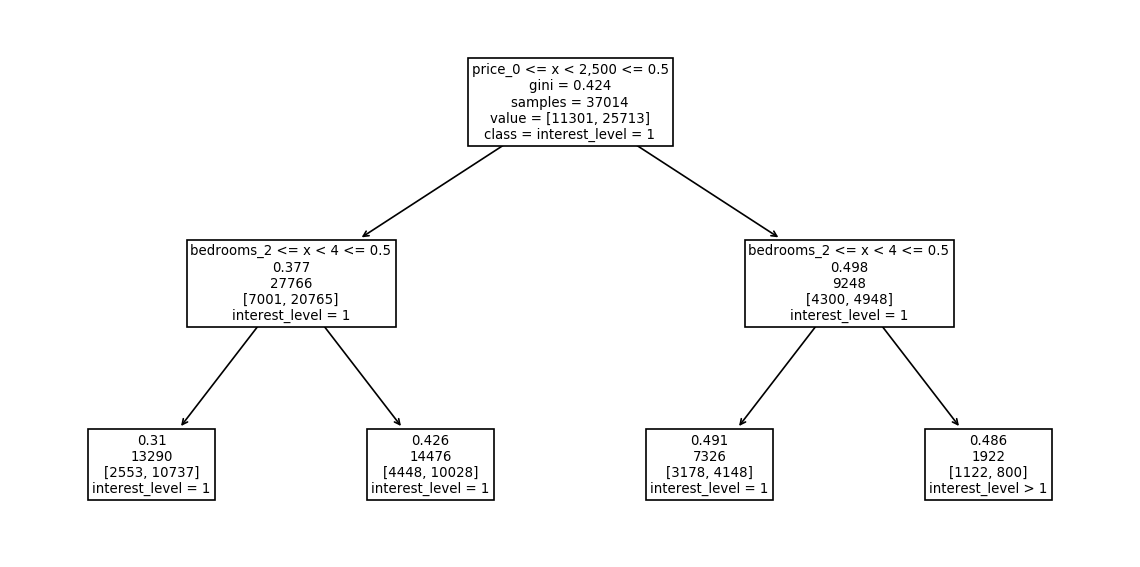

In [102]:
try:
    graph = Source(tree.export_graphviz(estimator, max_depth=2, out_file=None, feature_names=features, class_names=['chato', 'legal'],
       filled = True))
    display(SVG(graph.pipe(format='svg')))
    
except:
    # usar se graphviz não funcionar
    fig = plt.figure(figsize=(12, 6), dpi=120)
    ax = fig.add_subplot(111)
    _ = tree.plot_tree(estimator, max_depth=3, label='root', proportion=False,
        feature_names=features, class_names=['interest_level > 1', 'interest_level = 1'], ax=ax, fontsize=8)

In [39]:
estimator.score(X_test, y_test)

0.6984114118982007

* importância das features

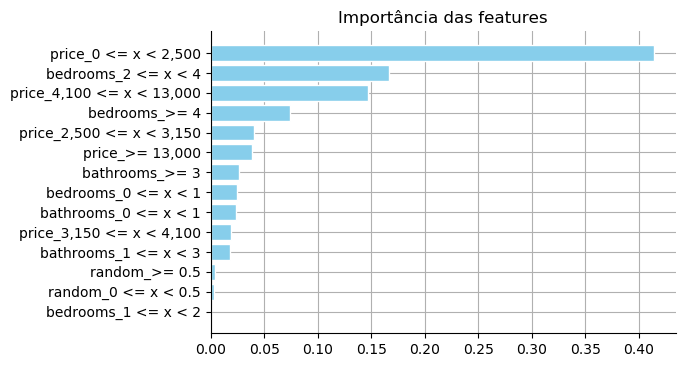

In [40]:
sorted_features = sorted(zip(features, estimator.feature_importances_), key=lambda elem: elem[1], reverse=True)

plt.rcParams['axes.axisbelow'] = True

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.barh(*zip(*sorted_features[:20][::-1]), color='skyblue', edgecolor='w')
plt.grid()
plt.title('Importância das features')
sns.despine()
plt.show()

### Comparação com xgboost + SHAP

In [41]:
dtrain = xgboost.DMatrix(X_train, label=y_train)

In [42]:
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'objective': 'reg:squarederror'
}

In [43]:
model = xgboost.train(params, dtrain=dtrain, evals=[(dtrain,'test'), (dtrain,'train')], early_stopping_rounds=1000, verbose_eval=0)

**Obtemos resultado similar ao do Corels**

In [44]:
dtest = xgboost.DMatrix(X_test, label=y_test)
accuracy_score(y_test, np.round(model.predict(dtest), 0))

0.6985735127249149

* SHAP

In [80]:
preds = np.round(model.predict(dtrain)) == 1

In [81]:
only_correct_X = X_train[y_train == preds]

In [82]:
explainer = shap.TreeExplainer(model)

In [83]:
shap_values = explainer.shap_values(only_correct_X)

In [84]:
shap_values_df = pd.DataFrame(data=shap_values, columns=features)

In [85]:
mean_shap_values_df = shap_values_df.abs().mean().reset_index()

In [86]:
mean_shap_values_df.columns = ['feature', 'shapley_value']

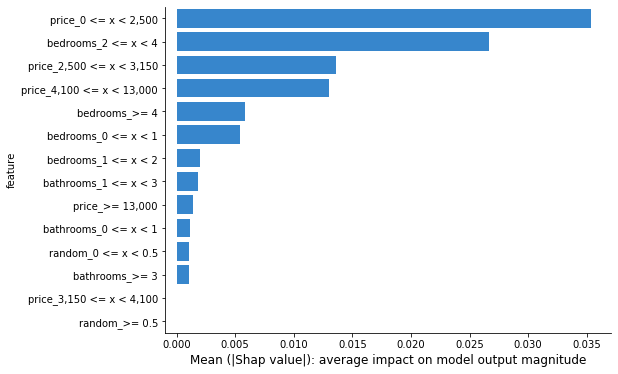

In [87]:
mean_shap_values_df = mean_shap_values_df.sort_values(by='shapley_value',ascending=False)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax = sns.barplot(x="shapley_value",
                 y="feature",
                 data=mean_shap_values_df,color='#1E88E5',ci=95)
sns.despine()
plt.xlabel("Mean (|Shap value|): average impact on model output magnitude",fontsize=12)
plt.xlim([-0.001, mean_shap_values_df['shapley_value'].max()*1.05])
plt.show()

* regra do Corels mais simples para comparação:

```python
RULELIST:
if [bedrooms_2 <= x < 4 && price_0 <= x < 2,500]:
    interest_level > 1
else 
    interest_level = 1
```

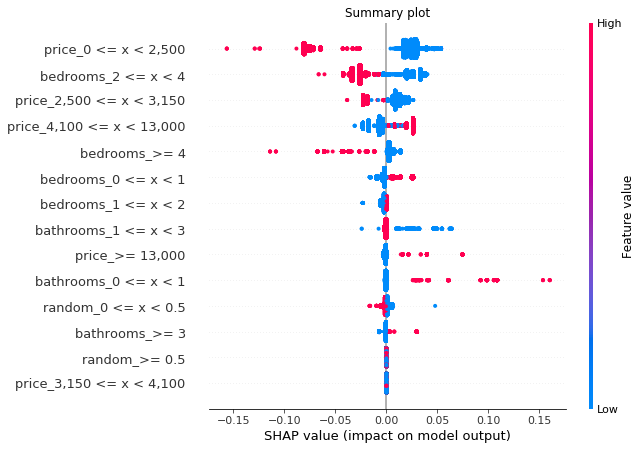

In [89]:
plt.figure()
plt.title(f'Summary plot')
shap.summary_plot(shap_values, only_correct_X, feature_names=features, plot_type="dot")
plt.show()

In [90]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(only_correct_X[:2000,:])

In [91]:
train_df['pred'] = preds

In [93]:
only_correct_train_df = train_df[train_df['pred'] == train_df[target_col]]
only_correct_train_df = only_correct_train_df.drop(['pred', target_col], 1)

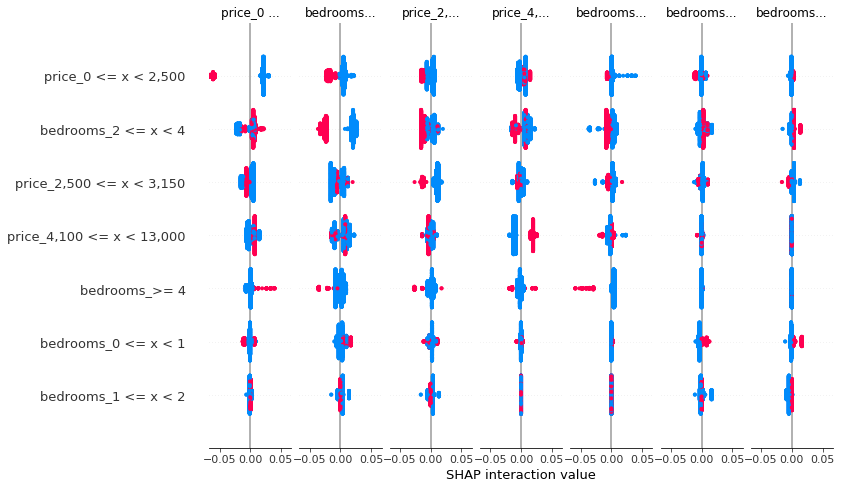

In [94]:
shap.summary_plot(shap_interaction_values, only_correct_train_df.iloc[:2000,:])

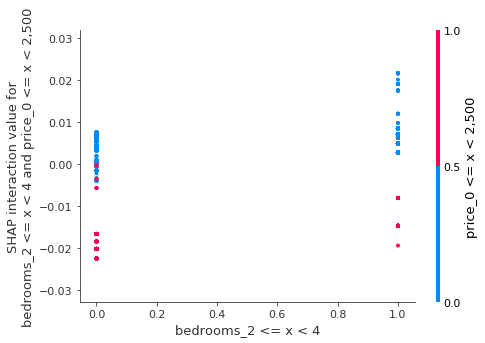

In [95]:
shap.dependence_plot(
    ('bedrooms_2 <= x < 4', 'price_0 <= x < 2,500'),
    shap_interaction_values, only_correct_train_df.iloc[:2000,:]
)

## CORELS + SHAP ?

In [55]:
n = 100

In [56]:
explainer_corels = shap.KernelExplainer(C.predict, X_test[:n])

In [57]:
shap_values_corels = explainer_corels.shap_values(X_test[:n])

100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


In [58]:
shap_values_corels_df = pd.DataFrame(data=shap_values_corels, columns=features)

In [59]:
mean_shap_values_corels_df = shap_values_corels_df.abs().mean().reset_index()

In [60]:
mean_shap_values_corels_df.columns = ['feature', 'shapley_value']

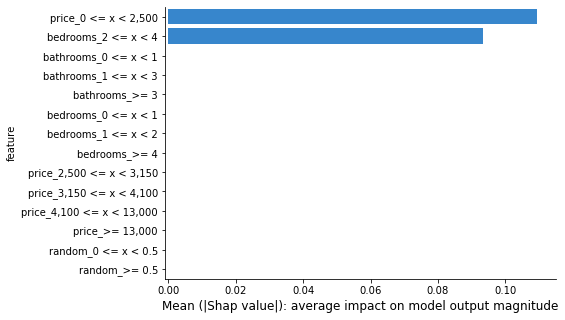

In [61]:
mean_shap_values_corels_df = mean_shap_values_corels_df.sort_values(by='shapley_value',ascending=False)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax = sns.barplot(x="shapley_value",
                 y="feature",
                 data=mean_shap_values_corels_df,color='#1E88E5',ci=95)
sns.despine()
plt.xlabel("Mean (|Shap value|): average impact on model output magnitude",fontsize=12)
plt.xlim([-0.001, mean_shap_values_corels_df['shapley_value'].max()*1.05])
plt.show()

* regra do Corels mais simples para comparação:

```python
RULELIST:
if [bedrooms_2 <= x < 4 && price_0 <= x < 2,500]:
    interest_level > 1
else 
    interest_level = 1
```

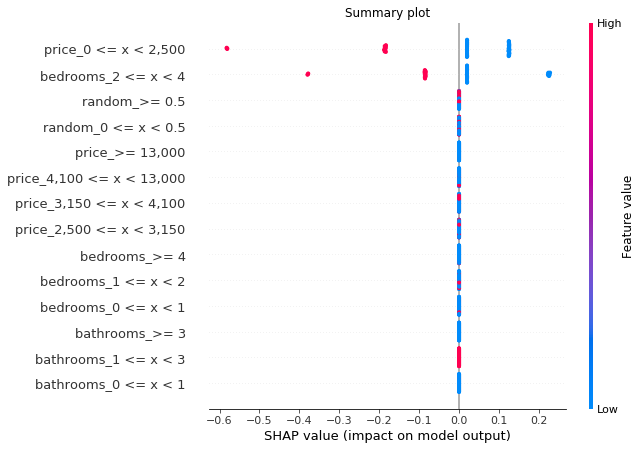

In [62]:
plt.figure()
plt.title(f'Summary plot')
shap.summary_plot(shap_values_corels, X_test[:n], feature_names=features, plot_type="dot")
plt.show()

* lembrando regra do Corels:

```python
RULELIST:
if [bedrooms_2 <= x < 4 && price_0 <= x < 2,500]:
    interest_level > 1
else 
    interest_level = 1
```

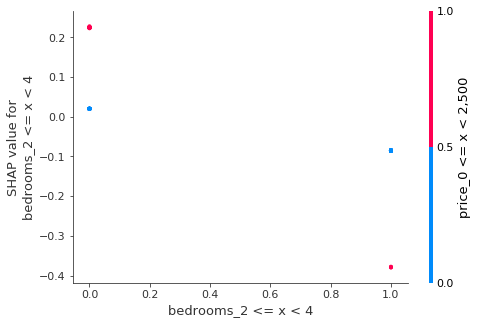

In [63]:
shap.dependence_plot('bedrooms_2 <= x < 4', shap_values_corels, test_df.drop(target_col, 1)[:n])